# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import ElasticNet

import warnings
warnings.filterwarnings("ignore")


# 2. Load Dataset

In [2]:
df = pd.read_csv('../data/glass.csv')

In [3]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


# 3. Exploratory Data Analysis (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [5]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


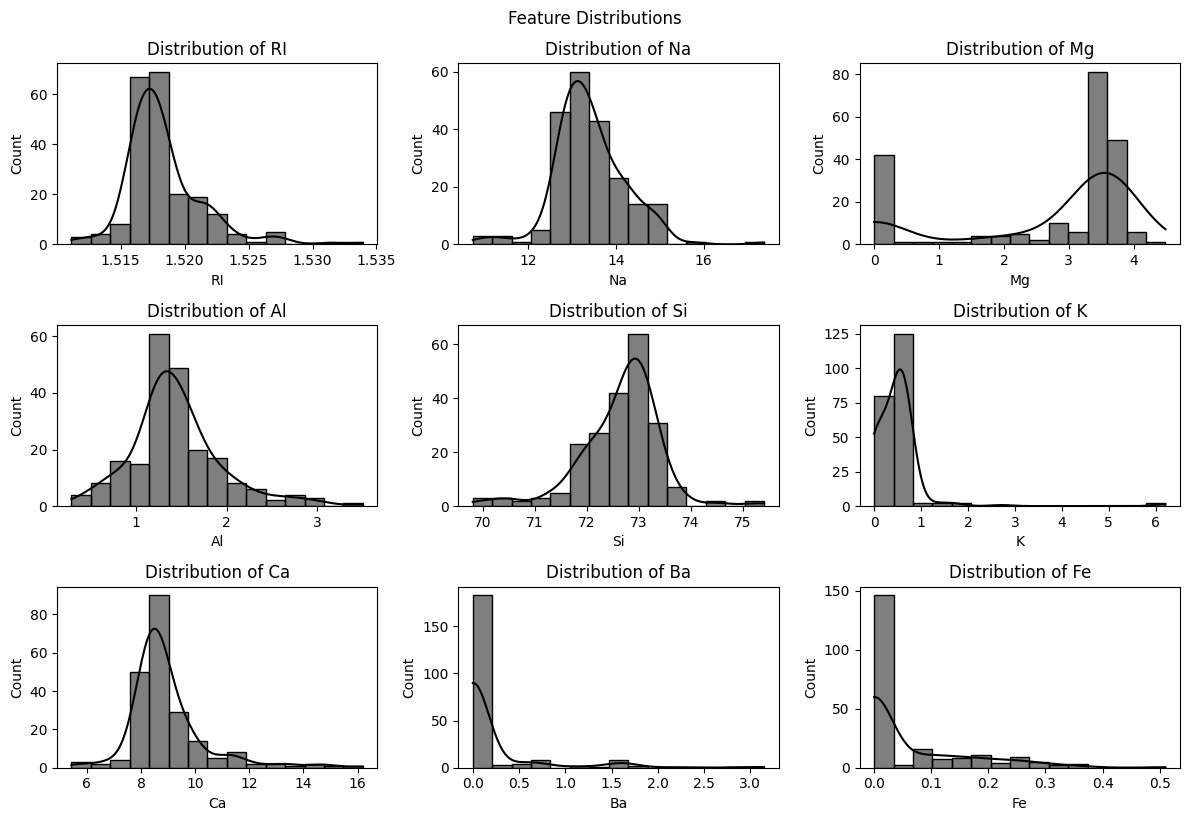

In [6]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], bins=15, kde=True, color='black')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.suptitle('Feature Distributions', y=1.02)
plt.show()

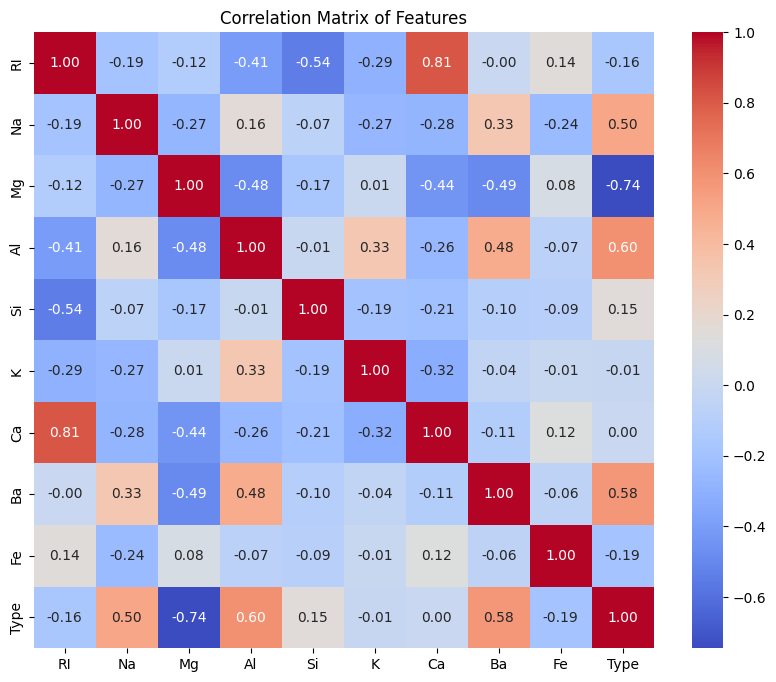

In [7]:
# Correlation between features
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

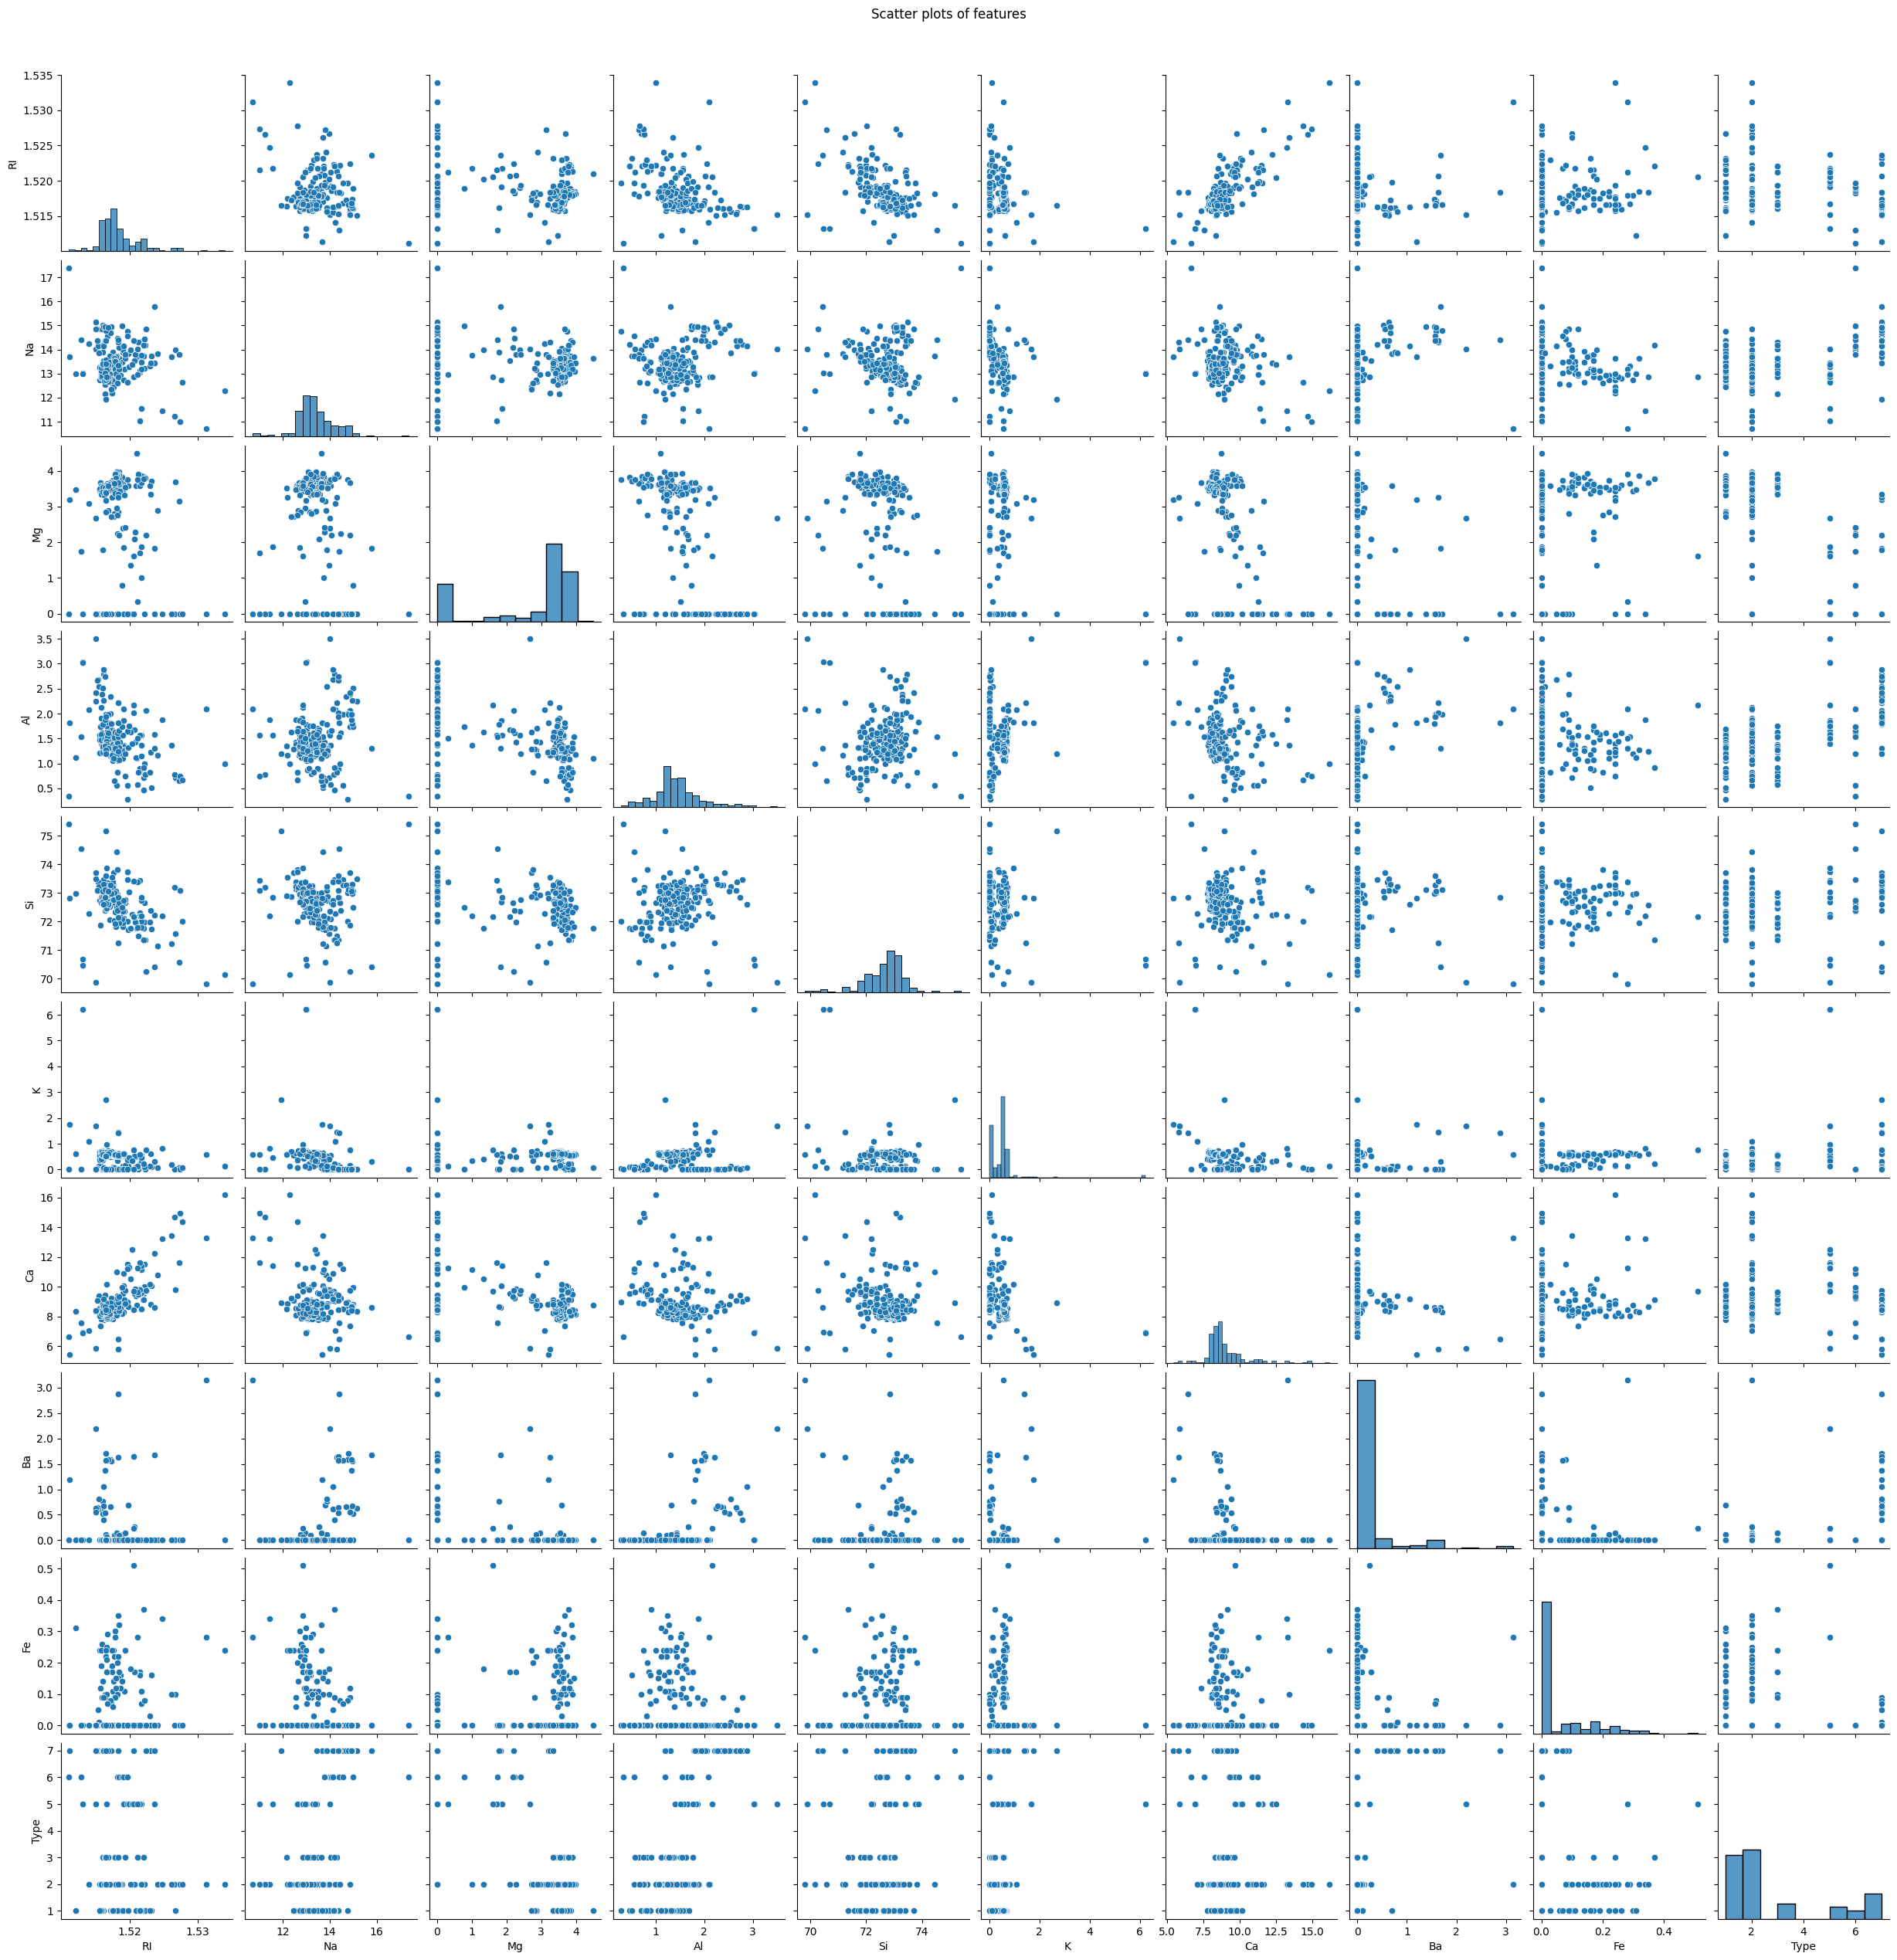

In [8]:
# Scatter plots: feature vs feature
sns.pairplot(df.iloc[:-1])  # exclude the last 'Type' feature
plt.suptitle('Scatter plots of features', y=1.02)
plt.show()

# Data Preprocessing

In [9]:
def replace_outliers_iqr(df, features, k=1.5):
    capped = df.copy()
    for col in features:
        Q1 = capped[col].quantile(0.25)
        Q3 = capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        capped[col] = np.where(capped[col] < lower, lower,
                               np.where(capped[col] > upper, upper, capped[col]))
    return capped

features = df.columns.drop('Type')
data_clean = replace_outliers_iqr(df, features)

In [10]:
y = data_clean['RI']
X = data_clean.drop(['RI'], axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
# Видаляємо рідкісні класи у колонці 'Type' (фічі), якщо їх менше 2
class_counts = df['Type'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df = df[df['Type'].isin(valid_classes)]

In [13]:
# Визначаємо числові та категоріальні фічі
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [14]:
numeric_transformer = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson'))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Build and Train Model

In [15]:
numeric_features = X.drop('Type', axis=1).columns
categorical_features = ['Type']

numeric_transformer = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Створюємо пайплайн з препроцесингом та регресором
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])


# Training with Hyperparameter Tuning

In [16]:
# Задаємо сітку параметрів для налаштування
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],          # Сила регуляризації
    'regressor__l1_ratio': [0.0, 0.1, 0.5, 0.7, 0.9, 1.0], # Баланс L1 (1) і L2 (0)
    'regressor__max_iter': [1000, 5000, 10000],            # Максимальна кількість ітерацій
    'regressor__tol': [1e-4, 1e-5, 1e-6],                  # Критерій зупинки (точність)
    'regressor__fit_intercept': [True, False],              # Чи навчати зсув (інтерсепт)
    'regressor__positive': [False, True]                    # Обмеження коефіцієнтів бути додатніми
}


# Налаштування з кросвалідацією
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Навчаємо
grid_search.fit(X_train, y_train)

/Users/arseniy.drobotenko/Documents/UNI/ML/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.348e-05, tolerance: 7.446e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/arseniy.drobotenko/Documents/UNI/ML/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.078e-05, tolerance: 7.431e-08 Linear regression models with null weight for the l1 regularization term are more ef

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('power',
                                                                                          PowerTransformer())]),
                                                                         Index(['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Type'])])),
                                       ('regressor', ElasticNet())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],
                         'regressor__fit_intercept': [True, False],
                         'regressor__l1_ratio': [0.0, 0.1, 0.5, 0.7, 0.9, 1.0],
                         'regressor__max_iter': [1000, 5000, 10000],
                         'regressor__positive': [False, True],
                         'regressor__tol': [0.0001, 1e-05, 1e-06]},
             scoring='neg_mean_squared_error')

In [17]:
# Кращі параметри
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_)**0.5)

# Фінальна модель
best_model = grid_search.best_estimator_

Best parameters: {'regressor__alpha': 0.01, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.0, 'regressor__max_iter': 10000, 'regressor__positive': False, 'regressor__tol': 0.0001}
Best RMSE: 0.001120426622612525


# Evaluation and Feature Importance

In [20]:
# Прогноз на тесті
y_pred = best_model.predict(X_test)

# Обчислення метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вивід
print(f"MAE:  {mae:.8f}")
print(f"MSE:  {mse:.8f}")
print(f"RMSE: {rmse:.8f}")
print(f"R²:   {r2:.8f}")

MAE:  0.00077694
MSE:  0.00000143
RMSE: 0.00119482
R²:   0.76505088


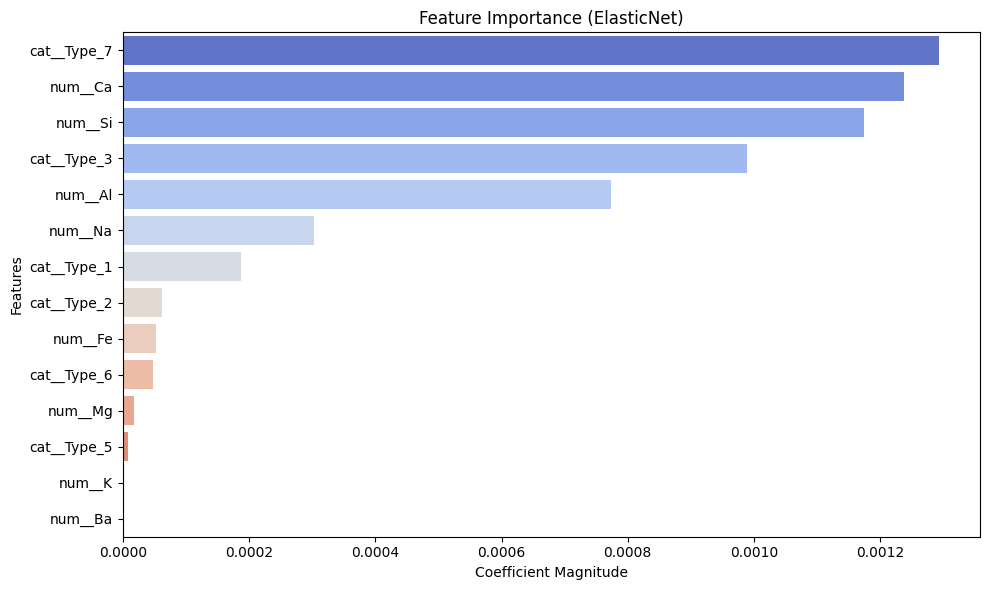

(14,)

In [19]:
# Отримуємо модель ElasticNet із пайплайну
elasticnet_model = best_model.named_steps['regressor']

# Отримуємо імена ознак після трансформацій (припускаємо, що вхід — DataFrame)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
coefs = elasticnet_model.coef_

# Створюємо DataFrame для візуалізації
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefs)
}).sort_values(by='Importance', ascending=False)

# Візуалізація
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.title('Feature Importance (ElasticNet)')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

feature_names.shape